In [1]:
import re
import os
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
url = "https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html"
        
url

'https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html'

In [4]:
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [9]:
divpage = r.html.find("div[class='col-xs-12 col-md-12']", first=True)
comunica_fechas = divpage.find("td[class='bmdateview']")
comunica_texto = divpage.find("td[class='bmtextview']")
# comunica_texto

In [10]:
values = []
for fechas, textos in zip(comunica_fechas, comunica_texto):
    fecha = fechas.find("span", first=True).text
    texto = textos.text
    abstract_url = textos.find("a", first=True).absolute_links
    abstract_url, *_ = abstract_url
    
    values.append([datetime.strptime(fecha, '%d/%m/%y'), re.sub('\n', ' ', texto), abstract_url, datetime.strptime(fecha, '%d/%m/%y').year])

In [12]:
df_values = pd.DataFrame(values, columns=["fecha", "texto", "url", "año"])
df_values = df_values[df_values["fecha"] >= '2008-02-15']
df_values = df_values.set_index("fecha")
df_values = df_values.sort_values("fecha", ascending=True)
df_values = df_values.join(df_values["texto"].str.extract(pat = '(incrementa|disminuye|mantiene)'), how='left').rename(columns={0: 'categoria'})
df_values.head()

,texto,url,año,categoria
fecha,,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,incrementa


In [22]:
#se guarda el dataFrame obtenido en un archivo .pkl
df_values.to_pickle("C:/Users/Palomino/Desktop/comunicadosbanxico.pkl")

In [29]:
#se cuentan las repeticiones de la columna category
cont=df_values.categoria.value_counts()
cont

mantiene      72
incrementa    18
disminuye     16
Name: categoria, dtype: int64

C:\Users\Palomino\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


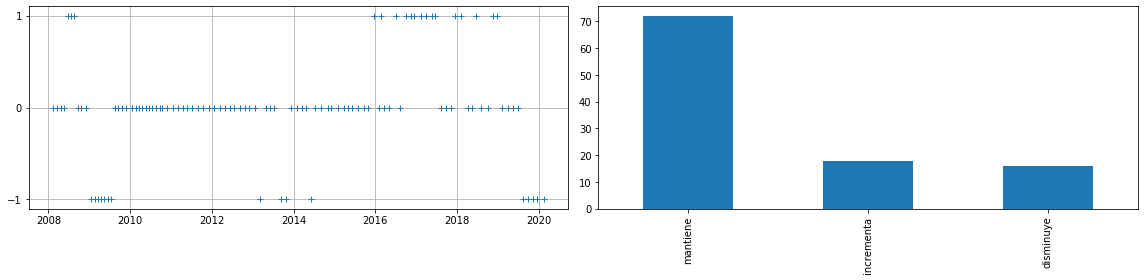

In [31]:
#se reenombran
valor_c = {'mantiene' : 0 , 'incrementa' : 1, 'disminuye' : -1}
graf=df_values.categoria.map(valor_c)

#se generan las dos graficas
fig, axes= plt.subplots(ncols=2, figsize=(16,4))
plt.setp(axes[0], yticks=([1, 0, -1]))
axes[0].grid()
axes[0].plot(graf.index,graf, '+')
df_values.categoria.value_counts().plot(kind='bar',ax=axes[1])
fig.tight_layout()

In [32]:
comunicado=df_values.categoria.groupby(df_values.index.year).value_counts()
comunicado.head()

fecha  categoria 
2008   mantiene       7
       incrementa     3
2009   disminuye      7
       mantiene       4
2010   mantiene      11
Name: categoria, dtype: int64

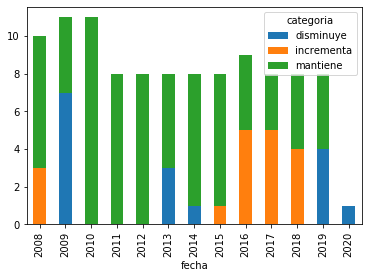

In [33]:
comunicado.unstack(level=1).plot.bar(stacked=True)

In [66]:
import nltk
from nltk import corpus
nltk.download('punkt')
nltk.download('stopwords')
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import PyPDF2
from sklearn.model_selection import train_test_split
import requests
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Palomino\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Palomino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# descarga papers 
for i in range(len(df_values)):
    url = df_values['url'][i]
    r = requests.get(url)
    
    paper = r.content

    # recomendable primero crear una carpeta si no existe donde guardaré mis pdfs
    if not os.path.exists("pdfs"):  
        os.mkdir("pdfs")
    
    full_path = os.path.join("pdfs", f"paper{i}.pdf")
    
    # escribe cada pdf en mi carpeta
    with open(full_path,"wb") as f: # wb write binary
        f.write(paper)

In [44]:
# lee papers y los guarda en un diccionario con disminuye, mantiene e incrementa como llaves

d = defaultdict(list)

for i in range(len(df_values)):
    
    full_path = os.path.join("pdfs", f"paper{i}.pdf")
    
    pdf_f = open(full_path, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_f)
    num_of_pages = read_pdf.getNumPages()
    c = Counter(range(num_of_pages))

    text_paper_i = ''
    for j in c:
       page = read_pdf.getPage(j)
       page_content = page.extractText()
       text_paper_i = text_paper_i + page_content # leemos el pdf completo y lo guardamos en text_paper_i
            
    d[df_values['categoria'][i]].append(text_paper_i)

In [45]:
k1, k2, k3 = 'mantiene', 'incrementa', 'disminuye'

In [46]:
def limpia_dialogo(texto):
    limpio = texto.lower()
    limpio = re.sub("[^\w ]", "", limpio) # quita lo que no sea alfanumerico o espacio 
    return limpio

In [47]:
D1 = [limpia_dialogo(doc) for doc in d[k1]]
D2 = [limpia_dialogo(doc) for doc in d[k2]]
D3 = [limpia_dialogo(doc) for doc in d[k3]]

# Partimos los datos en train y un test group

D1, D1_test = train_test_split(D1,test_size = 0.2)
D2, D2_test = train_test_split(D2,test_size = 0.2)
D3, D3_test = train_test_split(D3,test_size = 0.2)

In [48]:
N1 = len(D1)
N2 = len(D2)
N3 = len(D3)
N = N1 + N2 + N3
N

83

In [58]:
# Quitamos palabras inútiles 
stopwords = corpus.stopwords.words("spanish")
aditional_stopwords = ['mantener','disminuir','incrementar', 'mantengan','disminuyan','incrementen','además','general','vez']
stopwords = stopwords + aditional_stopwords
len(stopwords)

322

In [59]:
V1 = [palabra for dialogo in D1 for palabra in dialogo.split() if palabra not in stopwords]
V2 = [palabra for dialogo in D2 for palabra in dialogo.split() if palabra not in stopwords]
V3 = [palabra for dialogo in D3 for palabra in dialogo.split() if palabra not in stopwords]

In [60]:
V1_count = pd.Series(V1, name='k1').value_counts()
V2_count = pd.Series(V2, name = 'k2').value_counts()
V3_count = pd.Series(V3, name = 'k3').value_counts()

In [61]:
V = set(V1) | set(V2) | set(V3)
vocab = pd.DataFrame(index=V)
vocab.shape

(3171, 0)

In [64]:
# Verosimilitud
L = (vocab.join(V1_count, how = "left")
    .join(V2_count, how = "left")
    .join(V3_count, how = "left"))

L = L.fillna(0) + 1 #numerador 
L = L / L.sum(axis=0) # L.sum(axis=0)  suma el total por clase 

L.sort_values("k1",ascending = False)
L.sample(10)

,k1,k2,k3
repuntó,0.000099,0.000241,0.000117
desempeño,0.001381,0.001043,0.001865
variación,0.000526,0.000481,0.000466
solucionar,0.000066,0.000080,0.000117
reduzca,0.000099,0.000080,0.000350
acerca,0.000954,0.000241,0.000117
avances,0.000066,0.000080,0.000466
referencia,0.000822,0.000802,0.000933
combatir,0.000099,0.000080,0.000583
mejor,0.000691,0.000160,0.000699


In [67]:
log_L = np.log(L)

log_prior_k1 = np.log(N1/N)
log_prior_k2 = np.log(N2/N)
log_prior_k3 = np.log(N3/N)

log_priors = np.array([log_prior_k1,log_prior_k2,log_prior_k3])


In [68]:
len(D1_test)
d_test = D1_test[0]
f = set([palabra for palabra in d_test.split() if palabra in V])
res = log_L.loc[f].sum(axis=0) + log_priors
res

k1   -1482.219354
k2   -1518.819230
k3   -1500.074048
dtype: float64

In [72]:
D_test = D1_test + D2_test + D3_test
print(len(D_test))
t_test = ["k1"]*len(D1_test) + ["k2"]*len(D2_test) + ["k3"]*len(D3_test)

23


In [73]:
tt_test = [] 
for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    tt_test.append(res.idxmax())

print(t_test)
print(tt_test)

['k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k2', 'k2', 'k2', 'k3', 'k3', 'k3', 'k3']
['k1', 'k1', 'k1', 'k2', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k1', 'k2', 'k1', 'k2', 'k2', 'k1', 'k2', 'k2', 'k1', 'k1', 'k3', 'k1']


In [75]:
# Matriz de confusion
from  sklearn.metrics import confusion_matrix
confusion_matrix(t_test,tt_test)

array([[12,  3,  0],
       [ 1,  3,  0],
       [ 3,  0,  1]], dtype=int64)